# Signal selection

## Objectives:

   * **Define a selection** (a set of cuts on a list of variables) on *simulated data* samples to select $\beta\beta0\nu$ events and reject background, $^{214}\mathrm{Bi}$, $^{208}\mathrm{Tl}$, events.

## Physics

Using simulated data (signal and backgrounds) we define a selection to enhance the signal content in our data and reject the background.

For every decay in the detector a collection of variables are provided, for example, the number of tracks in the event, or the energy of the event.

We define a set of cuts on those variables to reduce the background and enhance the signal. 

We define an energy region of interest (RoI) where to perform a counting experiment.

### The detector

The detector of our data is a variation of the NEXT experiment, where $\beta\beta0\nu$ decays are detected in a Time Projection Chamber with:

  1) excellent energy resolution $<1$ \% FWHM

  2) tracking capabilities. 
  
$\beta\beta0\nu$ events are a unique track which a length of ~10 cm in the TPC that is made of two electrons. 

The detector reconstruct the track in 3D, and is able to identify the extremes of the track. In the case of the signal both extremes correspond to a Bragg peak, while for the electron, only one is a Bragg peak.

### The selection analysis

The main background are electrons produced in the $^{214}\mathrm{Bi}$ or the tail of $^{216}\mathrm{Tl}$ photopeak, while the signal is only one track composed with two electrons $\beta\beta0\nu$ with energy $Q_{\beta\beta}$

#### The main variables

The data is presented in a *panda* *DataFrame*, each row contains the information of one event

The relevant variables for an event are:

        * num_tracks, the number of tracks or separated depositions in the detector

        * E, energy (MeV) of the event

        * eblob2, energy (keV) on the extreme of the track with the lowest energy

#### Other variables

Other variables in the event are

        * length, the length of the track (mm)

        * num_voxels, the number of voxels (hits) of the event

        * eblob1, energy (keV) on the extreme of the track with the largest energy  

### The selection analysis

The typical selection requires the following cuts:


#### Number of tracks

Electrons radiate photons by bremsstrahlung that can produce other electrons. Each secondary electron can generate a track in the detector. In general, the signal has only one track while the backgrounds events have more than one track. 

We select events with only one track:

    * num_tracks == 1


#### Energy range

The relevant energy range is ( 2.400,  2.700) MeV, where the $^{216}\mathrm{Bi}$, $\beta\beta0\nu$ and $^{216}\mathrm{Tl}$ peaks are

We require an energy region for the events with one track:

    * (E >= 2.400) & (E < 2.700)


#### Energy of the 2nd blob

An electron at the of if its track deposits more energy in a Bragg peak (or blob). In the case of the signal, both track extremes are blobs, while for the background, which is made of a single electron, only one of the extremes is a real blob while the other, the start of the electron track, has much less energy.

We require an energy in the extreme with the lowest energy (or *second blob*) above an energy threshold, 400 keV

    * eblob2 > 400 

#### Energy Region of Interest, RoI 

Finally we select a narrow energy windows where most of the signal events are. 

We requiere that the energy of the tracks in ( 2.430,  2.480) MeV (the values could change for your detector)

    * (E >= 2.430) & ( E < 2.480)

## Selection

In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Importing modules

In [32]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants

import warnings
warnings.filterwarnings('ignore')

In [33]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
rootpath = os.getcwd()[:-15]
print('add path to PYTHONPATH : ', rootpath)
sys.path.insert(0, os.path.abspath(rootpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2/


In [34]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
pltext.style()

### Main parameters

In the next cell we define the main parameters of the selection

In [20]:
coll          = 'new_beta'
sel_ntracks  = 1
sel_eblob2   = 0.400 # MeV
sel_erange   = ( 2.400,  2.700) # MeV
sel_eroi     = ( 2.430,  2.480) # MeV

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : {:6d}'.format(sel_ntracks))
print('Blob-2 energy range       : {:6.3f}  MeV'.format(sel_eblob2))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*sel_erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*sel_eroi))

Collaboration             : new_beta
number of tracks range    :      1
Blob-2 energy range       :  0.400  MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


## Access the data

In the next cell we read the data (in a *h5* format), and access the simulated data of the backgrounds and the signal. 

We output the number of events in the simulated samples

In [21]:
# set the path to the data directory and filenames
dirpath = rootpath+'/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

# access the simulated data (DataFrames) for the different samples (Bi, Tl, bb) located in the data file
mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

# set the names of the samples
mc_samples         = [mcbi, mctl, mcbb] # list of the mc DFs
sample_names       = ['Bi', 'Tl', 'bb']
sample_names_latex = [ r'$^{214}$Bi', r'$^{208}$Tl', r'$\beta\beta0\nu$',] # str names of the mc samples

for i, mc in enumerate(mc_samples):
    print('MC Sample {:s}, number of simulated events = {:d}'.format(sample_names[i], len(mc)))

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2//data/fanal_new_beta.h5
MC Sample Bi, number of simulated events = 60184
MC Sample Tl, number of simulated events = 687297
MC Sample bb, number of simulated events = 47636


## inspect the variables



The next cell shows the some events of the simulated $\beta\beta0\nu$ data

In [22]:
# print the some contents of the DataFrame of the bb mc sample
mcbb

,mcE,E,num_tracks,num_voxels,track0_E,track0_voxels,track0_length,blob1_E,blob2_E,track1_E,track1_voxels,track1_length
0,2.457830,2.471280,1.0,17,2.471280,17.0,32.944061,NaN,NaN,NaN,NaN,NaN
1,1.627345,1.629487,1.0,13,1.629487,13.0,37.781500,0.841852,0.695263,NaN,NaN,NaN
2,2.457830,2.462075,1.0,14,2.462075,14.0,59.881962,0.961564,0.803745,NaN,NaN,NaN
3,2.457830,2.460759,1.0,21,2.460759,21.0,96.354208,1.005637,0.890549,NaN,NaN,NaN
4,2.457830,2.457934,2.0,20,2.428695,19.0,77.856795,NaN,NaN,0.029239,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
59993,2.457830,2.460685,1.0,16,2.460685,16.0,81.789893,1.051982,0.844432,NaN,NaN,NaN
59994,2.457830,2.461850,2.0,21,2.320462,19.0,74.822016,NaN,NaN,0.141387,2.0,17.020782
59996,2.457830,2.453377,1.0,22,2.453377,22.0,72.873822,0.902138,0.473505,NaN,NaN,NaN
59997,2.457830,2.455108,1.0,22,2.455108,22.0,35.444050,NaN,NaN,NaN,NaN,NaN


In [23]:
# list the variables
for label in mcbb.columns:
    print('variable : {:s}'.format(label))

variable : mcE
variable : E
variable : num_tracks
variable : num_voxels
variable : track0_E
variable : track0_voxels
variable : track0_length
variable : blob1_E
variable : blob2_E
variable : track1_E
variable : track1_voxels
variable : track1_length


### The distribution of the selection variables 

We plot the variables of the analysis for the different MC samples.

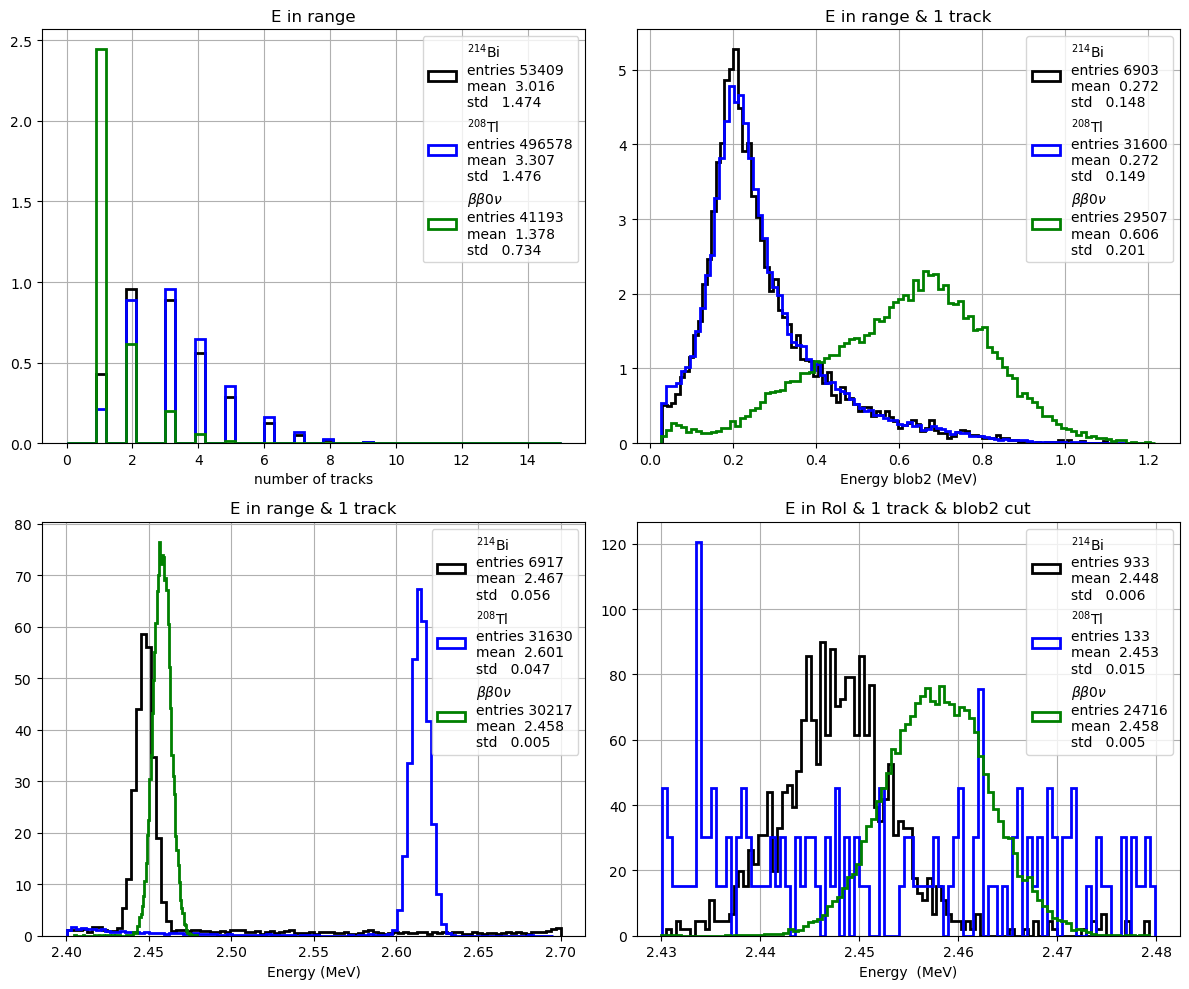

In [24]:
def plt_fanal_mc(bins = 100):
    """ Plot the relevant analysis variables, for the different mc samples
    """

    subplot = pltext.canvas(4)

    subplot(1)
    for i, mc in enumerate(mc_samples):
        sel  = (mc.E >= sel_erange[0]) & (mc.E < sel_erange[1])
        pltext.hist(mc.num_tracks[sel], int(bins/2), label = sample_names_latex[i],
                    density = True, range = (0, 15), lw = 2)
        plt.xlabel('number of tracks'); plt.title('E in range')

    subplot(2)
    for i, mc in enumerate(mc_samples):
        sel  = (mc.E >= sel_erange[0]) & (mc.E < sel_erange[1]) & (mc.num_tracks <= sel_ntracks)
        pltext.hist(mc.blob2_E[sel], bins,  label = sample_names_latex[i],
                    density = True, lw = 2)
        plt.xlabel('Energy blob2 (MeV)'); plt.title('E in range & 1 track')
        
    subplot(3)
    for i, mc in enumerate(mc_samples):
        sel = (mc.E >= sel_erange[0]) & (mc.E < sel_erange[1]) & (mc.num_tracks <= sel_ntracks)
        # sel = ut.in_range(mc.E, erange) equivalent using in_range method of utils
        pltext.hist(mc.E[sel], bins, label = sample_names_latex[i],
                    density = True, lw = 2)
        plt.xlabel('Energy (MeV)'); plt.title('E in range & 1 track');

    subplot(4)
    for i, mc in enumerate(mc_samples):
        sel  = (mc.E >= sel_eroi[0]) & (mc.E < sel_eroi[1]) & (mc.num_tracks <= sel_ntracks) & (mc.blob2_E >= sel_eblob2)
        pltext.hist(mc.E[sel], bins,  label = sample_names_latex[i], density = True, lw = 2)
        plt.xlabel('Energy  (MeV)'); plt.title('E in RoI & 1 track & blob2 cut') 
    
    plt.tight_layout();
    return

plt_fanal_mc()

**Exercise**: Study the variables and decide wich ones have the larges discrimination power between signal and background.

## Efficiencies

We compute the efficiency of each of the selection cut and the efficiency of the selection for the bkg and the signal

In the example, only the efficiency for the signal is printed and plotted.

**Explore** Inspect what is the meaning of *mask* in the following cells

**Exercise** Compute the efficiencies for the background

In [28]:
# names in the plot
sample_efficiencies = []

def efficiency(mask):
    return float(sum(mask)/len(mask))

for mc in mc_samples:

    mask1 = mc.num_tracks <= sel_ntracks
    eff1  = efficiency(mask1)
    
    mask2 = mask1 & (mc.blob2_E > sel_eblob2)
    eff2  = efficiency(mask2)
    
    mask3 = mask2 & (mc.E >= sel_erange[0]) & (mc.E < sel_erange[1])
    eff3  = efficiency(mask3)

    mask4 = mask3 & (mc.E >= sel_eroi[0]) & (mc.E < sel_eroi[1])
    eff4  = efficiency(mask4)
    
    sample_efficiencies.append((eff1, eff2, eff3, eff4))
    
sel_names  = ["track", "E blob2", "E", "RoI"]

for i, ieffs in enumerate(sample_efficiencies):
    print('Efficiencies ' + sample_names[i], ': ', \
          *[' {:s} = {:6.5f}, '.format(s, eff) for s, eff in zip(sel_names, ieffs)])

Efficiencies Bi :   track = 0.14504,   E blob2 = 0.01929,   E = 0.01799,   RoI = 0.01550, 
Efficiencies Tl :   track = 0.04630,   E blob2 = 0.00734,   E = 0.00730,   RoI = 0.00019, 
Efficiencies bb :   track = 0.71757,   E blob2 = 0.57719,   E = 0.51906,   RoI = 0.51885, 


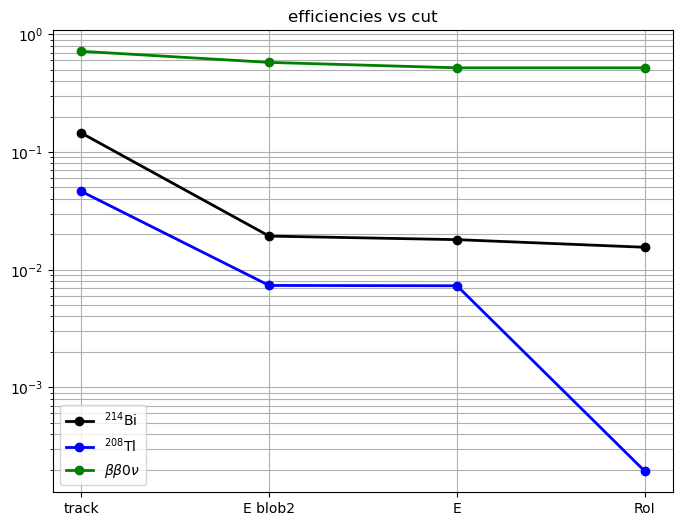

In [29]:
subplot = pltext.canvas(1, 1, 6, 8)
subplot(1)
for sample, efficiencies in zip(sample_names_latex, sample_efficiencies):
    plt.plot(sel_names, efficiencies, marker = 'o', label = sample, lw = 2)
plt.grid(which = 'both'); plt.yscale('log'); plt.legend();
plt.title('efficiencies vs cut');

### Write out

We write the relevant python variables into a file, called *collpars.py*, which contains the relevant parameters of the analysis and which will be used in the following notebooks. 

We write out into the parameter file:

  * The selection cuts
  * The efficiencies of the selection for each sample


**NOTE** It is importat that you save the values the variables with their names into the parameters file, *collpars.py*. These variables will be used later in the other NBs. 

In [30]:
write = False
collpar_filename = "collpars.py" #name of the file with the parameters
if (write):
    of = open(collpar_filename, 'a')
    of.write('collaboration   = "' + coll + '"\n')
    of.write('sel_ntracks     = ' + str(sel_ntracks) + '\n')
    of.write('sel_eblob2      = ' + str(sel_eblob2) + ' # MeV\n')
    of.write('sel_erange      = ' + str(sel_erange) + ' # MeV\n')
    of.write('sel_eroi        = ' + str(sel_eroi)   + ' # MeV\n')
    for sample, efficiencies in zip(sample_names, sample_efficiencies):
        of.write('eff_'+sample+'_E        = {:1.2e}'.format(efficiencies[-2])+'\n')
        of.write('eff_'+sample+'_RoI      = {:1.2e}'.format(efficiencies[-1])+'\n')
    of.close()